# Plots moments and stuff for passive learning

Comes from `LearningModels/examples/full_gmm_procedure_real_data_passive_learning.py`

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#######################
#
# Passive Learning
#
###########################


import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
import time
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append('../../')
import src
from src.utils import myopic_price
from numba import njit

np.random.seed(383461)
#GMM parameters
maxiters = 100 #100, 1.2 minutos por iteración
time_periods = 40 #Maximum spell_t to consider
min_periods = 3 #Min window period for standard deviation
use_logs_for_x = False
print(f"Started at {time.asctime()}. Discount: {src.const.δ}. {maxiters} maxiters. Logs for x? {use_logs_for_x}")

#Load policy and value function
#####################
file_n = "2019-4-27medium_prod_vfi_dict.dill" #discount 0.95 (I think)
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Passive learning policy function
def policyF(curr_lambdas: np.array):
    """
    For passive learning, the optimal price is a function of
    the expected elasticity
    """
    full_lambdas = np.concatenate((curr_lambdas, 1 - np.array([curr_lambdas.sum()])))
    return myopic_price(full_lambdas, betas_transition=src.const.betas_transition)

#dataframe and standard deviation
cleaned_data = "../../../firm_learning/data/cleaned_data/"

df = pd.read_csv(cleaned_data + "medium_prod_for_gmm.csv")
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=min_periods)
            .std().reset_index()
            .rename(columns={'level_1': 't', 'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')
df["dmd_shocks"] = np.random.normal(loc=0, scale=src.const.σ_ɛ, size=len(df))

#Fix beta_0 and taste shocks for all t and all firms
n_firms = df.firm.nunique()
max_t_periods_in_data = df.groupby('firm').log_dmd.count().max()
taste_shocks = np.random.normal(loc=0, scale=src.const.taste_shock_std,
                                size=(max_t_periods_in_data, n_firms))
b0 = np.clip(np.random.normal(loc=src.const.mature_beta, scale=src.const.beta_shock_std, size=n_firms),
             -np.inf, -1.05)


#mean_std_observed_prices = df.groupby('t').std_dev_prices.mean()[min_periods:]
mean_std_observed_prices = df.groupby('t').rolling_std_upc.mean()[min_periods:]

#Mix Max scaling for xs
if use_logs_for_x:
    xs = np.log(df.groupby('firm').xs.first().values + 0.1)
else:
    xs = (df.groupby('firm').xs.first().values + 0.1)
scaler = MinMaxScaler()
xs = scaler.fit_transform(xs.reshape(-1, 1)).flatten()

Nfirms = len(xs)
# Just add zeroes. Makes sense for the gmm estimation
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=0)


# Betas inertia procedure
@njit()
def new_generate_betas_inertia(firm_periods: int, i_firm: int) -> np.array:
    """
    Generates the vector of beta demands for a firm for a total of t periods
    given by the parameter firm_periods

    :param firm_periods:
    :param i_firm:
    :return:
    """
    betas = np.empty(firm_periods)
    betas[0] = b0[i_firm]
    old_beta = b0[i_firm]
    for t_ in range(1, firm_periods):
        new_beta = src.nb_clip(src.const.γ * old_beta + taste_shocks[t_, i_firm], -np.inf, -1.05)
        betas[t_] = new_beta
        old_beta = new_beta

    return betas

df["betas_inertia"] = 0.

#New Procedure
for i_firm, firm in enumerate(df.firm.unique()):
    mask: pd.Series = (df.firm == firm)
    t = mask.sum()
    df.loc[mask, "betas_inertia"] = new_generate_betas_inertia(t, i_firm)



# Optimization
######################

#Parameter limits that make sense for the product (Hand-picked this time)
optimization_limits = [(-4, 0.05), (-5, 4), (0.2, 1.35), (-1, 1)]

def error_w_data(θ) -> float:
    return src.gmm_error(θ, policyF, xs,
                         mean_std_observed_prices=mean_std_observed_prices, df=df,
                         prior_shocks=prior_shocks, min_periods=min_periods)


Started at Fri Jun 21 13:45:33 2019. Discount: 0.95. 100 maxiters. Logs for x? False


## Plot real vs expected moments

In [19]:
lambdas0

array([[0.29704305, 0.70295695, 0.        ],
       [0.30483741, 0.69516259, 0.        ],
       [0.26691764, 0.73308236, 0.        ],
       ...,
       [0.30793165, 0.69206835, 0.        ],
       [0.299787  , 0.700213  , 0.        ],
       [0.28252612, 0.71747388, 0.        ]])

In [26]:
1.00000000e+000

1.0

In [34]:
def get_pricing_decisions(policyF_, lambdas_at_0):
    pricing_decision_dfs = []
    for i, firm in enumerate(df.firm.unique()):
        prices = src.generate_pricing_decisions(policyF_, lambdas_at_0[i],
                                            df[df.firm == firm].log_dmd.values,
                                            df[df.firm == firm].dmd_shocks.values,
                                            df[df.firm == firm].betas_inertia.values)
        pricing_decision_dfs.append(pd.DataFrame({'level_prices': prices,
                                                  'firm': np.repeat(firm, len(prices))
                                                  }))

    pricing_decision_df = pd.concat(pricing_decision_dfs, axis=0)
    return pricing_decision_df
    
    
    

In [43]:
prices_per_t.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
           dtype='int64', name='index')

In [45]:
prices_per_t.values

array([84.03970203, 84.29896186, 84.80404027, 85.02483457, 85.15209042,
       85.12781732, 84.71727492, 84.58461006, 84.91131991, 84.74574993,
       84.59777058, 83.80480127, 83.63969216, 83.7222911 , 84.24954043,
       84.21146759, 84.9285246 , 84.91971037, 84.7821229 , 85.03529412,
       84.84999976, 86.00000042, 85.73256512, 84.98632789, 85.50636117,
       87.27743559, 87.22577863, 87.21627906, 87.17241379, 87.11111111,
       88.        , 88.        , 88.        , 88.        , 88.        ,
       88.        , 88.        , 88.        , 88.        , 88.        ,
       88.        , 88.        , 88.        , 88.        , 88.        ,
       88.        , 88.        , 88.        , 88.        ])

initial lambdas: [0.00809525 0.00936935 0.9825354 ]


Text(0.5, 1.0, 'Simulated prices')

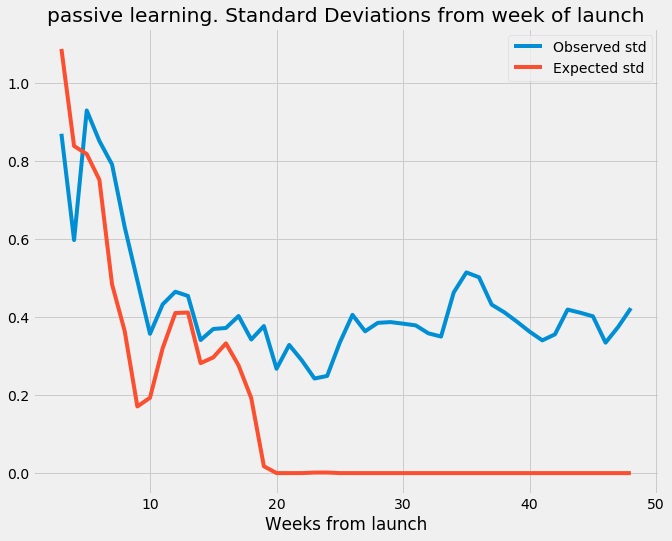

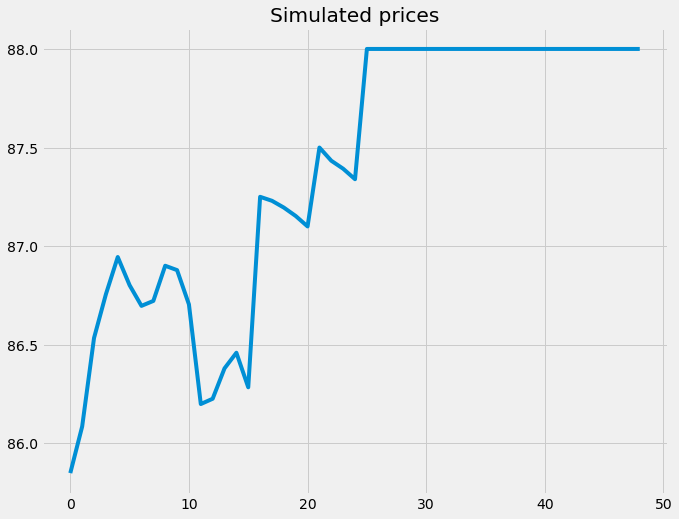

In [49]:
optθ = np.array([-25.57,  60.91, -15.3,   12.33]) #passive
lambdas0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

active_policyF = src.interpolate_wguess(lambdas_ext, policy)
def passive_policyF(curr_lambdas: np.array):
    """
    For passive learning, the optimal price is a function of
    the expected elasticity
    """
    full_lambdas = np.concatenate((curr_lambdas, 1 - np.array([curr_lambdas.sum()])))
    return myopic_price(full_lambdas, betas_transition=src.const.betas_transition)

whichpolicy = 'passive'
if whichpolicy == 'passive':
    whichpolicyF = passive_policyF
elif whichpolicy == 'active':
    whichpolicyF = active_policyF
else: raise ValueError("Use either passive or active")

price_df = get_pricing_decisions(whichpolicyF, lambdas0)  
price_df = get_pricing_decisions(whichpolicyF, lambdas0)  
price_df.reset_index(inplace=True)
prices_per_t = price_df.groupby('index').level_prices.mean()

exp_prices = []
obs_prices = []
for i in range(3):
    np.random.seed(i)
    df["betas_inertia"] = 0.
    #New Procedure
    for i_firm, firm in enumerate(df.firm.unique()):
        mask: pd.Series = (df.firm == firm)
        t = mask.sum()
        df.loc[mask, "betas_inertia"] = new_generate_betas_inertia(t, i_firm)
    mean_std_observed_prices_clean, mean_std_expected_prices = (
             src.get_intersection_of_observed_and_expected_prices(
                     mean_std_observed_prices, df, whichpolicyF, lambdas0, 3))
    exp_prices.append(mean_std_expected_prices)


exp_prices_df = pd.concat(exp_prices, axis=1)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ind_t = mean_std_expected_prices.index
ax1.plot(ind_t, mean_std_observed_prices_clean, label="Observed std")
#ax1.plot(ind_t, mean_std_expected_prices, label="Expected std")
ax1.plot(ind_t, exp_prices_df.mean(axis=1), label="Expected std")
ax1.legend()
ax1.set_title(f"{whichpolicy} learning. Standard Deviations from week of launch")
ax1.set_xlabel("Weeks from launch")

print(f"initial lambdas: {lambdas0.mean(axis=0)}")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(prices_per_t.index, prices_per_t.values)
ax.set_title("Simulated prices")


initial lambdas: [4.39556745e-32 9.99965295e-01 3.47047701e-05]


Text(0.5, 1.0, 'Simulated prices')

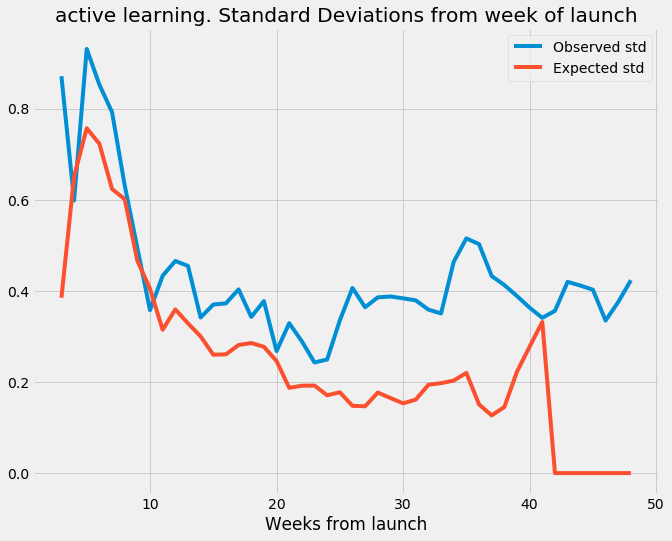

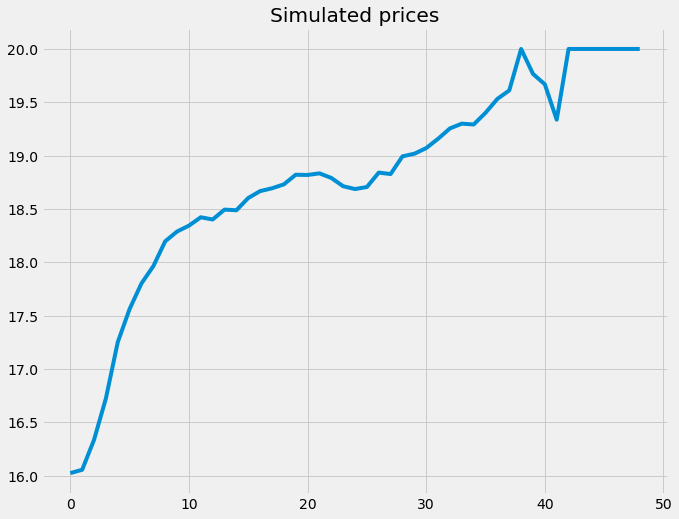

In [48]:
optθ = np.array([-3.97, -4.98, 1.09, -0.83])

lambdas0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

active_policyF = src.interpolate_wguess(lambdas_ext, policy)
def passive_policyF(curr_lambdas: np.array):
    """
    For passive learning, the optimal price is a function of
    the expected elasticity
    """
    full_lambdas = np.concatenate((curr_lambdas, 1 - np.array([curr_lambdas.sum()])))
    return myopic_price(full_lambdas, betas_transition=src.const.betas_transition)

whichpolicy = 'active'
if whichpolicy == 'passive':
    whichpolicyF = passive_policyF
elif whichpolicy == 'active':
    whichpolicyF = active_policyF
else: raise ValueError("Use either passive or active")

price_df = get_pricing_decisions(whichpolicyF, lambdas0)  
price_df = get_pricing_decisions(whichpolicyF, lambdas0)  
price_df.reset_index(inplace=True)
prices_per_t = price_df.groupby('index').level_prices.mean()

exp_prices = []
obs_prices = []
for i in range(3):
    np.random.seed(i)
    df["betas_inertia"] = 0.
    #New Procedure
    for i_firm, firm in enumerate(df.firm.unique()):
        mask: pd.Series = (df.firm == firm)
        t = mask.sum()
        df.loc[mask, "betas_inertia"] = new_generate_betas_inertia(t, i_firm)
    mean_std_observed_prices_clean, mean_std_expected_prices = (
             src.get_intersection_of_observed_and_expected_prices(
                     mean_std_observed_prices, df, whichpolicyF, lambdas0, 3))
    exp_prices.append(mean_std_expected_prices)


exp_prices_df = pd.concat(exp_prices, axis=1)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ind_t = mean_std_expected_prices.index
ax1.plot(ind_t, mean_std_observed_prices_clean, label="Observed std")
#ax1.plot(ind_t, mean_std_expected_prices, label="Expected std")
ax1.plot(ind_t, exp_prices_df.mean(axis=1), label="Expected std")
ax1.legend()
ax1.set_title(f"{whichpolicy} learning. Standard Deviations from week of launch")
ax1.set_xlabel("Weeks from launch")

print(f"initial lambdas: {lambdas0.mean(axis=0)}")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(prices_per_t.index, prices_per_t.values)
ax.set_title("Simulated prices")
